In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from dpm.visualize import plot_hist, plot_model, plot_models, plot_hists

colors = { 0:"#003f5c", 1:"#444e86", 2:"#955196", 3:"#dd5182", 4:"#ff6e54", 5:"#ffa600"}

# Approximating Pi

In [2]:
def plot_samples(samples, distances, n_plot=10000):
    idx = torch.randperm(min(n_plot, samples.size(0)))
    p_samples, distances = samples[idx], distances[idx]
    accepted = p_samples[distances < 1.].numpy()
    rejected = p_samples[distances >= 1.].numpy()
    plt.figure(figsize=(7, 7))
    plt.scatter(accepted[:, 0], accepted[:, 1], s=4); plt.scatter(rejected[:, 0], rejected[:, 1], s=4)
    plt.xlim(0., 1.); plt.ylim(0., 1.)
    

def sample(batch_size):
    return torch.rand((batch_size, 2))

def distance(samples):
    return samples.pow(2).sum(dim=1).sqrt()

def monte_carlo(batch_size, plot=False):
    samples = sample(batch_size)
    distances = distance(samples)
    if plot: plot_samples(samples, distances)
    ratio = 4 * (distances < 1.).float().sum() / batch_size
    return ratio

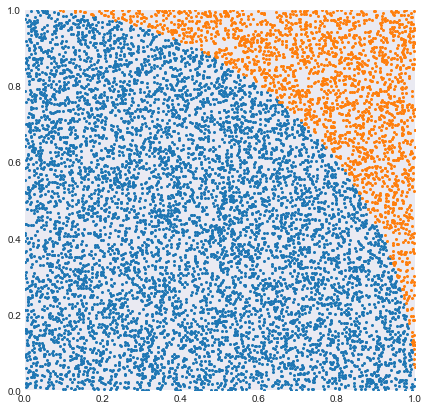

In [3]:
monte_carlo(100000, plot=True)
plt.grid(b=None)
# plt.savefig('../../Presentations/sampling/assets/approx_pi_circle.png', bbox_inches='tight', dpi=300)
plt.show()

In [4]:
def plot_monte_carlo_err(batch_size):
    samples = sample(batch_size)
    distances = distance(samples)
    print(distances.shape, samples.shape)
    ratio = 4 * torch.cumsum((distances < 1.).float(), 0) / torch.cumsum(torch.ones(batch_size).float(), 0)
    return ratio

torch.Size([100000]) torch.Size([100000, 2])


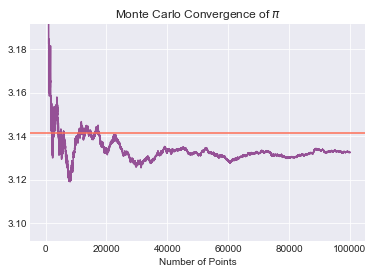

In [5]:
plt.plot(plot_monte_carlo_err(100000).numpy(), color="#955196")
plt.ylim(np.pi-0.05, np.pi+.05)
plt.axhline(np.pi, color='#ff6e54')
plt.title(r"Monte Carlo Convergence of $\pi$")
plt.xlabel('Number of Points')
# plt.grid(b=None)
# plt.savefig('../../Presentations/sampling/assets/approx_pi_error.png', bbox_inches='tight', dpi=300)
plt.show()

# LCG

In [6]:
from dpm.monte_carlo import rand, lcg

g = lcg()
for i in range(10):
    print(next(g))

1680588
675057779
713713492
1295248114
689724154
1311030043
827663638
1788785909
852207936
356854227


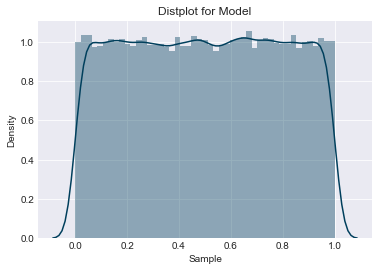

In [7]:
plot_hist(rand(100000, generator=g))

# Box Muller

In [8]:
from dpm.monte_carlo import box_muller
from dpm.visualize import plot_hist

In [9]:
# Works!
Z1, Z2 = box_muller()
print(Z1.shape, Z2.shape)
print(Z1.mean(), Z1.var())
print(Z2.mean(), Z2.var())

torch.Size([10000, 1]) torch.Size([10000, 1])
tensor(0.0022) tensor(0.9847)
tensor(-0.0025) tensor(1.0036)


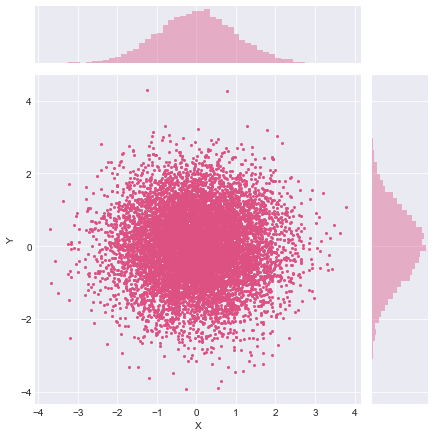

In [10]:
plot_hist(torch.cat((Z1, Z2), dim=1))
plt.show()

# Marsaglia - Bray

In [11]:
from dpm.monte_carlo import marsaglia_bray
from dpm.visualize import plot_hist

In [12]:
# Works!
Z1, Z2 = marsaglia_bray()
print(Z1.shape, Z2.shape)
print(Z1.mean(), Z1.var())
print(Z2.mean(), Z2.var())

torch.Size([7771, 1]) torch.Size([7771, 1])
tensor(5.4379e-05) tensor(1.0122)
tensor(-0.0059) tensor(1.0120)


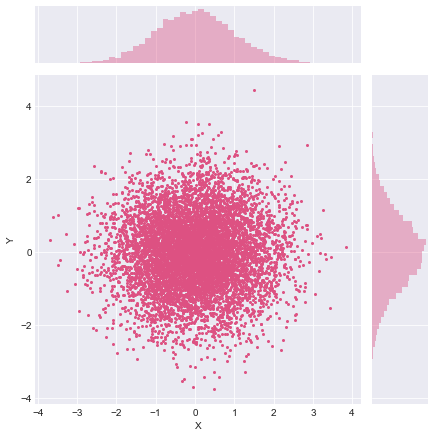

In [13]:
plot_hist(torch.cat((Z1, Z2), dim=1))
plt.show()

# Normal ICDF

In [14]:
from dpm.monte_carlo import inverse_sampling
from functools import partial

def normal_icdf(p, mu, sigma):
    return mu + sigma * np.sqrt(2.) * torch.erfinv(2 * p - 1)

n_icdf = partial(normal_icdf, mu=0., sigma=1.)

torch.Size([10000, 1])
tensor([0.0098]) tensor([0.9997])


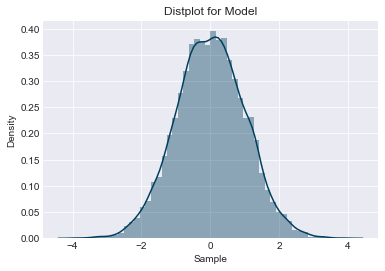

In [15]:
samples = inverse_sampling(n_icdf)
print(samples.shape)
print(samples.mean(dim=0), samples.var(dim=0))
plot_hist(samples)

torch.Size([10000, 2])
tensor([-0.0028,  0.0217]) tensor([0.9757, 0.9993])


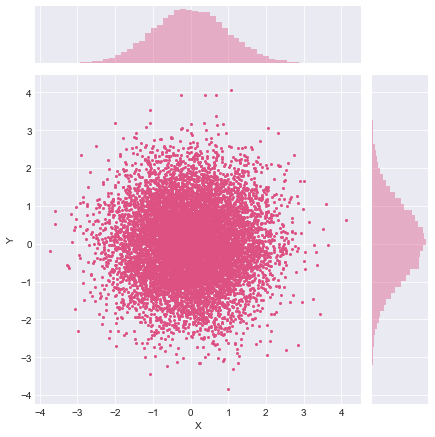

In [16]:
samples = inverse_sampling(n_icdf, n_dims=2)
print(samples.shape)
print(samples.mean(dim=0), samples.var(dim=0))
plot_hist(samples)

# Rejection Sampling

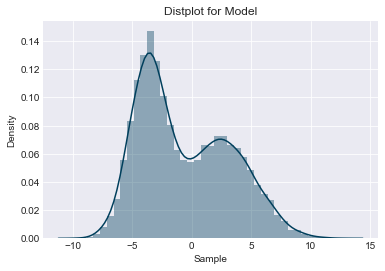

In [17]:
from dpm.distributions import Normal
from dpm.mixture_models import MixtureModel

p_model = MixtureModel([Normal(-3.7, 2.3, learnable=False), 
                        Normal(2.6, 7.5, learnable=False)],
                       [0.5, 0.5])
q_model = Normal(0., 100., learnable=False)
plot_model(p_model)

torch.Size([10071, 1])


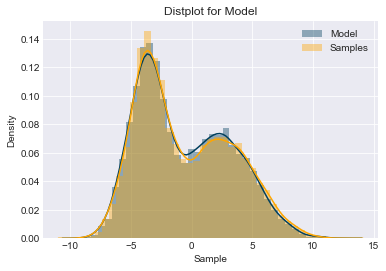

In [18]:
from dpm.monte_carlo import rejection_sampling

samples = rejection_sampling(p_model, q_model, 10, batch_size=100000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

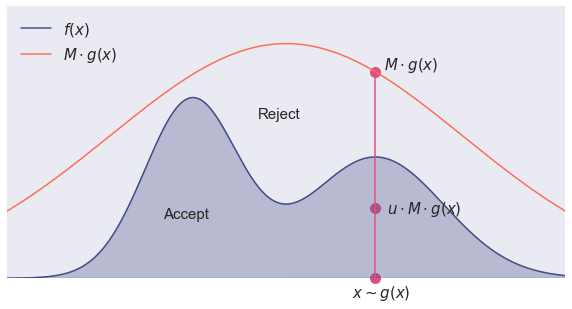

In [19]:
p_model = MixtureModel([Normal(-1.7, 0.7, learnable=False), 
                        Normal(1.6, 1.5, learnable=False)],
                       [0.5, 0.5])
q_model = Normal(0., 10., learnable=False)

M = 2.5

x = np.linspace(-7, 7, 1000).reshape(-1, 1)
plt.figure(figsize=(10,5))
p_probs = p_model.log_prob(torch.tensor(x).float()).exp().numpy()
q_probs = M*q_model.log_prob(torch.tensor(x).float()).exp().numpy()

plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.plot(x, p_probs , color=colors[1], label=r"$f(x)$")
plt.plot(x, q_probs, color=colors[4], label=r"$M \cdot g(x)$")
plt.fill(x, p_probs, color=colors[1], alpha=0.3)

# x_sample = q_model.sample(1)
x_sample = torch.tensor([[1.6]])
u = 0.34
top = M * q_model.log_prob(x_sample).exp().item()
point = u * M * q_model.log_prob(x_sample).exp().item()

plt.scatter(x_sample.item(), 0, s=100, color=colors[3], clip_on=False)
plt.scatter(x_sample.item(), top, s=100, color=colors[3], clip_on=False)
plt.scatter(x_sample.item(), point, s=100, color=colors[3], clip_on=False)

plt.annotate("Accept", (-2.2, 0.08), fontsize=15)
plt.annotate("Reject", (-0.5, 0.215), fontsize=15)

plt.annotate(r"$x \sim g(x)$", (x_sample.item(), 0), 
             fontsize=15, xytext=(x_sample.item()+0.1, -0.025), ha='center')

plt.annotate(r"$M \cdot g(x)$", (x_sample.item(), top),
             fontsize=15, xytext=(x_sample.item()+0.15, top+0.004), ha='left')

plt.annotate(r"$u \cdot M \cdot g(x)$", (x_sample.item(), point),
             fontsize=15, xytext=(x_sample.item()+0.2, point-0.007), ha='left')

plt.axvline(x_sample.item(), ymin=0, ymax=top/(np.max(q_probs)+.05), color=colors[3])

plt.legend(loc='upper left', prop={'size': 15})

plt.xlim(-5, 5)
plt.ylim(0, np.max(q_probs)+.05)
plt.grid(b=None)

plt.savefig('../../Presentations/sampling/assets/rejection_sampling_explanation.png', bbox_inches='tight', dpi=300)

plt.show()

6688


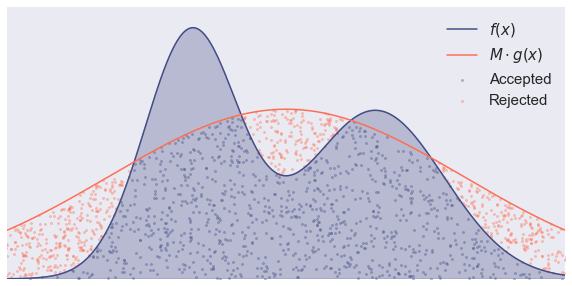

(6688,)


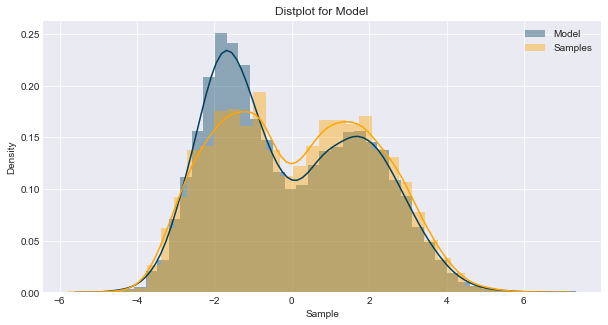

In [121]:
def rejection_sampling(model, test_model, M, batch_size=10000):
    model_samples = test_model.sample(batch_size)
    uniform_samples = torch.rand(batch_size).log()
    acceptance_ratio = (model.log_prob(model_samples) \
                       - test_model.log_prob(model_samples) \
                       - np.log(M))
    accepted = uniform_samples < acceptance_ratio
    return model_samples[accepted], model_samples[~accepted], uniform_samples[accepted].exp(), uniform_samples[~accepted].exp()

plt.figure(figsize=(10,5))


M = 1.3
N = 1000

a_samples, r_samples, u_a, u_r = rejection_sampling(p_model, q_model, M, batch_size=10000)

a_probs = q_model.log_prob(a_samples).exp().view(-1)
r_probs = q_model.log_prob(r_samples).exp().view(-1)

a_samples = a_samples.view(-1).numpy()
r_samples = r_samples.view(-1).numpy()
print(len(a_samples))

a_points = (u_a * a_probs * M).numpy()
r_points = (u_r * r_probs * M).numpy()

idx = np.random.choice(range(len(a_samples)), min(N, len(a_samples)), replace=False)
a_sam = a_samples
a_points = a_points[idx]
a_samples = a_samples[idx]
idx = np.random.choice(range(len(r_samples)), min(N, len(r_samples)), replace=False)
r_points = r_points[idx]
r_samples = r_samples[idx]


plt.scatter(a_samples, a_points, color=colors[1], label="Accepted", alpha=0.3, s=4)
plt.scatter(r_samples, r_points, color=colors[4], label="Rejected", alpha=0.3, s=4)

x = np.linspace(-7, 7, 1000).reshape(-1, 1)
p_probs = p_model.log_prob(torch.tensor(x).float()).exp().numpy()
q_probs = M*q_model.log_prob(torch.tensor(x).float()).exp().numpy()

plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.plot(x, p_probs , color=colors[1], label=r"$f(x)$")
plt.plot(x, q_probs, color=colors[4], label=r"$M \cdot g(x)$")
plt.fill(x, p_probs, color=colors[1], alpha=0.3)

plt.legend(loc='best', prop={'size': 15})

plt.xlim(-5, 5)
plt.ylim(0, max(np.max(q_probs), np.max(p_probs))+.02)
plt.grid(b=None)

# plt.savefig(f'../../Presentations/sampling/assets/rs_m_1_3.png', bbox_inches='tight', dpi=300)

plt.show()

plt.figure(figsize=(10,5))
plot_hists(p_model.sample(10000), a_sam, labels=['Model', 'Samples'])
print(a_sam.shape)
# plt.savefig(f'../../Presentations/sampling/assets/rs_hist_1_3.png', bbox_inches='tight', dpi=300)
plt.show()



# MCMC

torch.Size([900, 1])


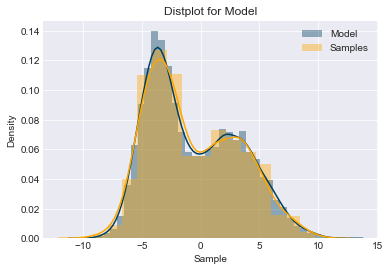

In [24]:
from dpm.monte_carlo import metropolis

samples = metropolis(p_model, keep_every=10, burn_in=1000, variance=3 * torch.eye(1), epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

torch.Size([900, 1])


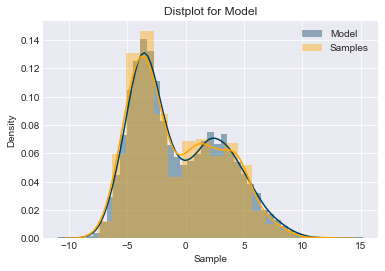

In [25]:
from dpm.monte_carlo import metropolis_hastings
from functools import partial

q_model = partial(Normal, scale=3 * torch.eye(1), learnable=False)

samples = metropolis_hastings(p_model, q_model, keep_every=10, burn_in=1000, epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

torch.Size([900, 1])


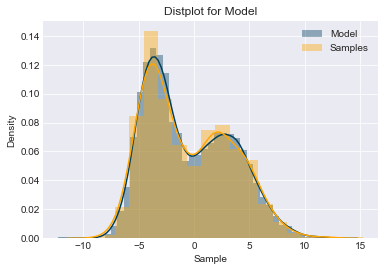

In [27]:
from dpm.monte_carlo import metropolis_langevin

samples = metropolis_langevin(p_model, keep_every=10, burn_in=1000, epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])